<a href="https://colab.research.google.com/github/TanushGoel/Earthquake-Damage/blob/master/Earthquake_Damage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# imports
import pandas as pd
pd.options.mode.use_inf_as_na = False
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [0]:
# dataframe storage reduction
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [0]:
# train data
data = pd.read_csv('model_quake_damage_train.csv')
data.head()

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade
0,802906,6,487,12198,2,30,6,5,t,r,n,f,q,t,d,1,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,3
1,28830,8,900,2812,2,10,8,7,o,r,n,x,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,2
2,94947,21,363,8973,2,10,5,5,t,r,n,f,x,t,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,3
3,590882,22,418,10694,2,10,6,5,t,r,n,f,x,s,d,0,1,0,0,0,0,1,1,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,2
4,201944,11,131,1488,3,30,8,9,t,r,n,f,x,s,d,1,0,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,3


In [0]:
# swap letters for specific number values in the data

def map_data(df):

  # each unique letter associated with one number increasing from 1 alphabetically
  # eg. a = 1, c=2, d=3, f=4, h=5
  df.land_surface_condition = df.land_surface_condition.map({'t':14, 'o':10, 'n':9})
  df.foundation_type = df.foundation_type.map({'r':12, 'w':17, 'i':6, 'u':15, 'h':5})
  df.roof_type = df.roof_type.map({'n':9, 'q':11, 'x':18})
  df.ground_floor_type = df.ground_floor_type.map({'f':4, 'x':18, 'v':16, 'z':19, 'm':8})
  df.other_floor_type = df.other_floor_type.map({'q':11, 'x':18, 'j':7, 's':13})
  df.position = df.position.map({'t':14, 's':13, 'j':7, 'o':10})
  df.plan_configuration = df.plan_configuration.map({'d':3, 'u':15, 's':13, 'q':11, 'm':8, 'c':2, 'a':1, 'n':9, 'f':4, 'o':10})
  df.legal_ownership_status = df.legal_ownership_status.map({'v':16, 'a':1, 'r':12, 'w':17})
  
  return df

In [0]:
data = map_data(data)
data.drop('building_id', axis=1, inplace=True)

In [0]:
data.head()

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade
0,6,487,12198,2,30,6,5,14,12,9,4,11,14,3,1,1,0,0,0,0,0,0,0,0,0,16,1,0,0,0,0,0,0,0,0,0,0,0,3
1,8,900,2812,2,10,8,7,10,12,9,18,11,13,3,0,1,0,0,0,0,0,0,0,0,0,16,1,0,0,0,0,0,0,0,0,0,0,0,2
2,21,363,8973,2,10,5,5,14,12,9,4,18,14,3,0,1,0,0,0,0,0,0,0,0,0,16,1,0,0,0,0,0,0,0,0,0,0,0,3
3,22,418,10694,2,10,6,5,14,12,9,4,18,13,3,0,1,0,0,0,0,1,1,0,0,0,16,1,0,0,0,0,0,0,0,0,0,0,0,2
4,11,131,1488,3,30,8,9,14,12,9,4,18,13,3,1,0,0,0,0,0,0,0,0,0,0,16,1,0,0,0,0,0,0,0,0,0,0,0,3


In [0]:
data.isnull().sum()

geo_level_1_id                            0
geo_level_2_id                            0
geo_level_3_id                            0
count_floors_pre_eq                       0
age                                       0
area_percentage                           0
height_percentage                         0
land_surface_condition                    0
foundation_type                           0
roof_type                                 0
ground_floor_type                         0
other_floor_type                          0
position                                  0
plan_configuration                        0
has_superstructure_adobe_mud              0
has_superstructure_mud_mortar_stone       0
has_superstructure_stone_flag             0
has_superstructure_cement_mortar_stone    0
has_superstructure_mud_mortar_brick       0
has_superstructure_cement_mortar_brick    0
has_superstructure_timber                 0
has_superstructure_bamboo                 0
has_superstructure_rc_non_engine

In [0]:
# test data
data_test = pd.read_csv('model_quake_damage_test.csv')
data_test.head()

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
0,300051,17,596,11307,3,20,7,6,t,r,n,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
1,99355,6,141,11987,2,25,13,5,t,r,n,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,1,1,0,0,0,0,0,0,0,0,0
2,890251,22,19,10044,2,5,4,5,t,r,n,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
3,745817,26,39,633,1,0,19,3,t,r,x,v,j,t,d,0,0,0,0,0,1,0,0,0,0,0,v,2,1,0,0,1,0,0,0,0,0,0,0
4,421793,17,289,7970,3,15,8,7,t,r,q,f,q,t,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0


In [0]:
data_test = map_data(data_test)
building_ids = data_test.building_id
data_test.drop('building_id', axis=1, inplace=True)

In [0]:
data_test.head()

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
0,17,596,11307,3,20,7,6,14,12,9,4,11,13,3,0,1,0,0,0,0,0,0,0,0,0,16,1,0,0,0,0,0,0,0,0,0,0,0
1,6,141,11987,2,25,13,5,14,12,9,4,11,13,3,0,1,0,0,0,0,0,0,0,0,0,16,1,1,1,0,0,0,0,0,0,0,0,0
2,22,19,10044,2,5,4,5,14,12,9,4,11,13,3,0,1,0,0,0,0,0,0,0,0,0,16,1,0,0,0,0,0,0,0,0,0,0,0
3,26,39,633,1,0,19,3,14,12,18,16,7,14,3,0,0,0,0,0,1,0,0,0,0,0,16,2,1,0,0,1,0,0,0,0,0,0,0
4,17,289,7970,3,15,8,7,14,12,11,4,11,14,3,0,1,0,0,0,0,0,0,0,0,0,16,1,0,0,0,0,0,0,0,0,0,0,0


Text(0.5, 1.0, '# of Buildings for each Damage Grade')

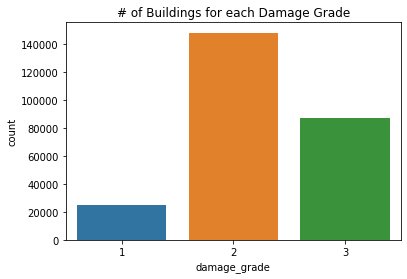

In [0]:
sns.countplot(data['damage_grade'])
plt.title('# of Buildings for each Damage Grade')

Text(0.5, 1, 'Variable Correlations')

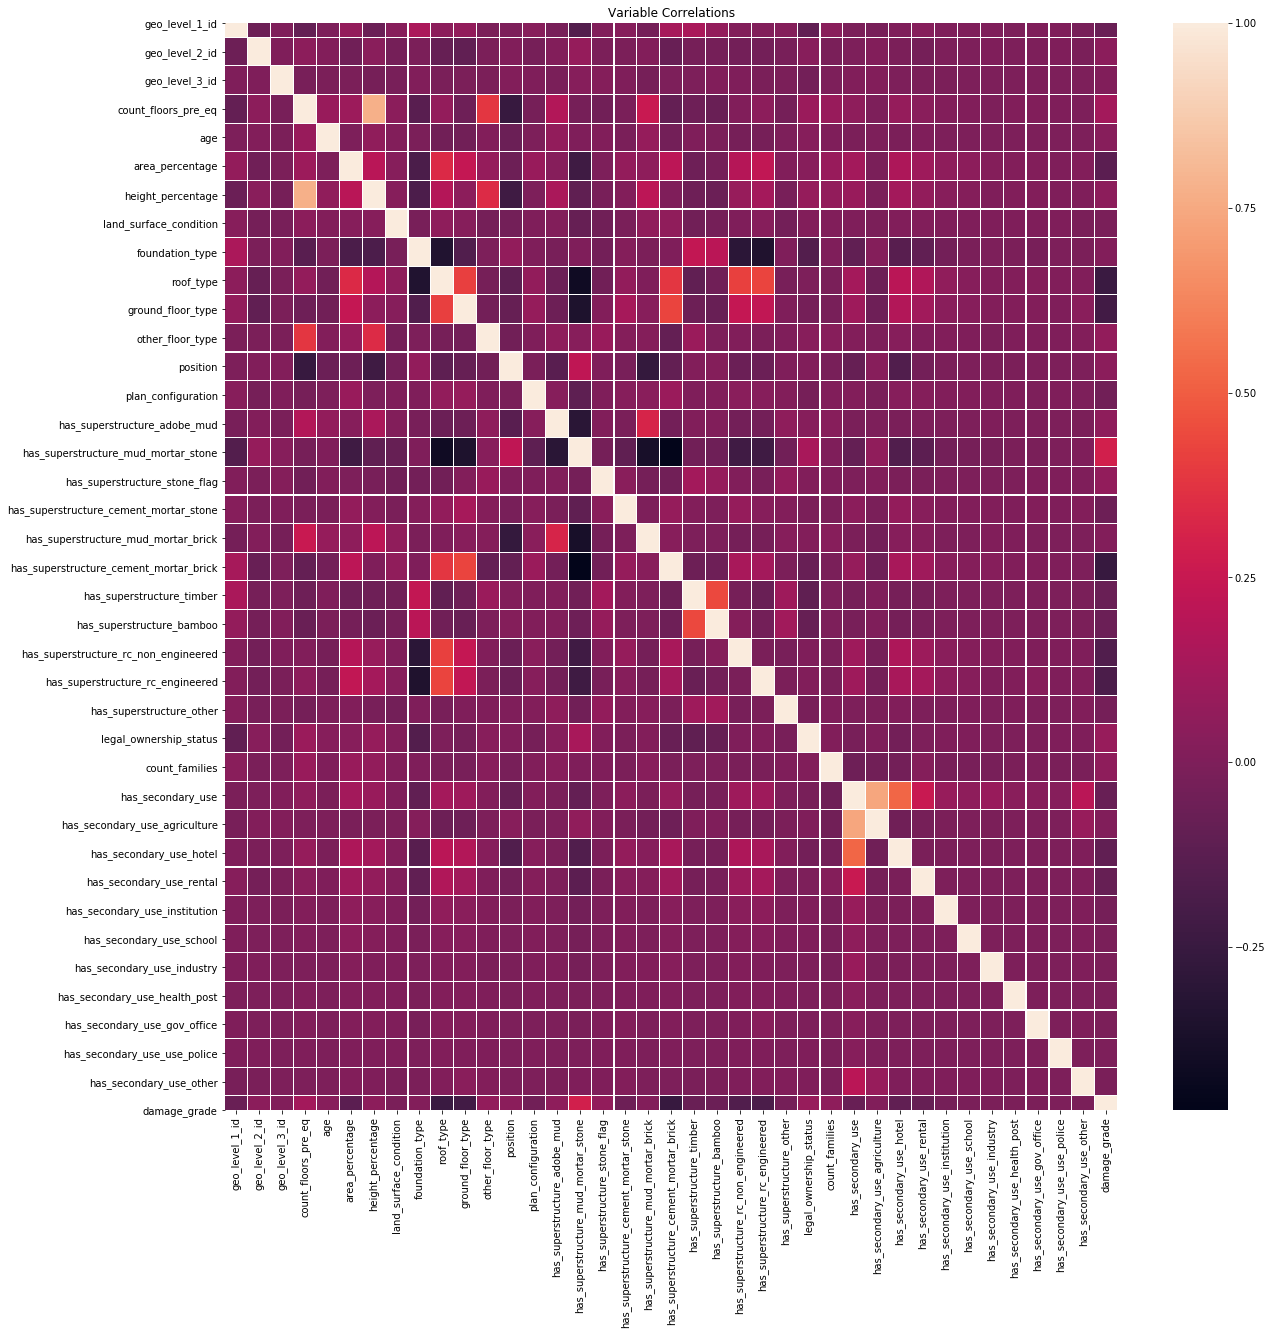

In [0]:
# feature correlation heatmap

import seaborn as sns
correlations = data.corr()
fig, ax = plt.subplots(figsize=(20,20))
corr_heat = sns.heatmap(correlations, linewidths=0.125, ax=ax)
plt.title('Variable Correlations')

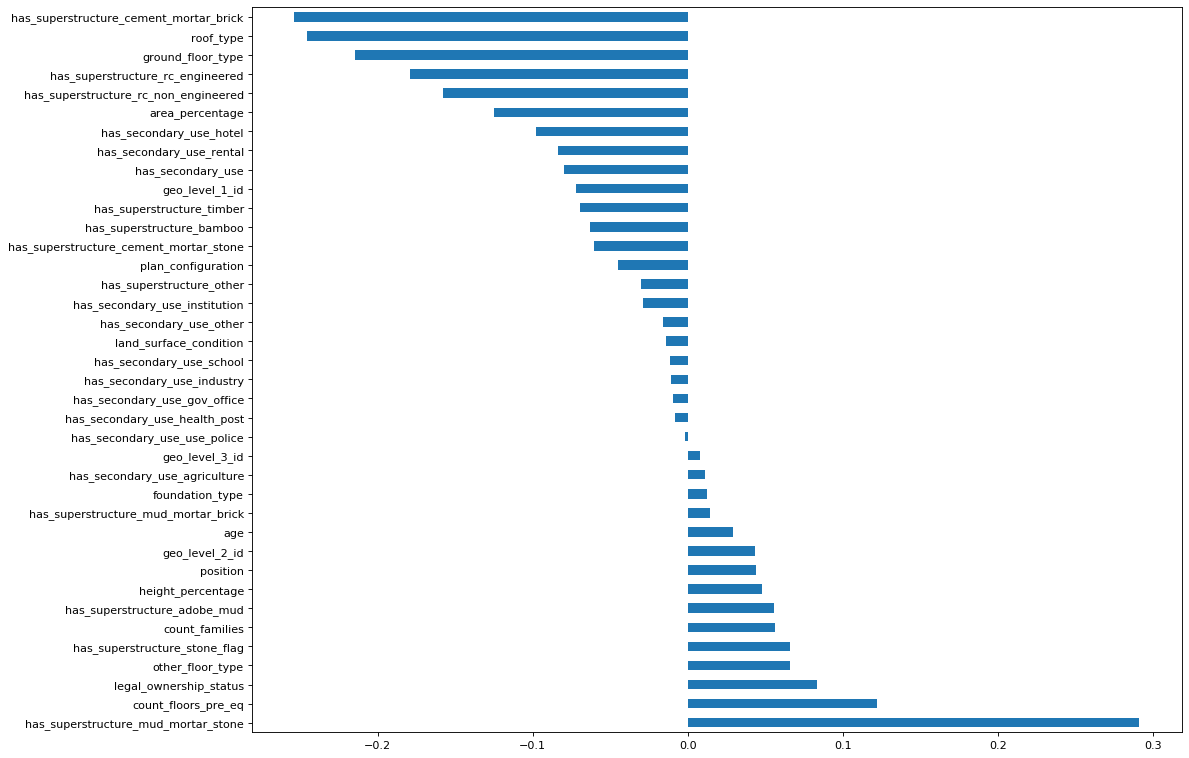

In [0]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(15,12), dpi=80, facecolor='w', edgecolor='k')
correlations.damage_grade.drop('damage_grade').sort_values(ascending=False).plot.barh()

In [0]:
features = data.drop('damage_grade', axis=1)

In [0]:
list_features = list(features.columns)
feature_length = len(list_features)

In [0]:
# determine the best features to use for the model

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

X = features # independent columns
y = data.damage_grade # target column

# apply SelectKBest class to extract best features
bestfeatures = SelectKBest(score_func=chi2, k=feature_length)
fit = bestfeatures.fit(X, y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

# concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns, dfscores],axis=1)
featureScores.columns = ['Feature', 'Score']  # naming the dataframe columns
print(featureScores.nlargest(feature_length, 'Score'))  # print best features

del features, list_features, featureScores, dfcolumns, dfscores, X, y

                                   Feature          Score
1                           geo_level_2_id  128238.967548
4                                      age   89437.601578
2                           geo_level_3_id   83664.759136
10                       ground_floor_type   64361.382843
0                           geo_level_1_id   24186.950757
19  has_superstructure_cement_mortar_brick   18949.414382
23        has_superstructure_rc_engineered   14411.297027
5                          area_percentage   11938.314627
9                                roof_type   11873.966190
22    has_superstructure_rc_non_engineered    8725.518483
15     has_superstructure_mud_mortar_stone    6969.601844
29                 has_secondary_use_hotel    2937.304376
30                has_secondary_use_rental    2635.341540
27                       has_secondary_use    1485.663306
14            has_superstructure_adobe_mud    1340.145544
11                        other_floor_type    1267.776540
3             

In [0]:
# add new features 

def add_features(df):
  
  df["width_percentage"] = df.area_percentage - df.height_percentage + 30
  df["type"] = df.foundation_type * df.roof_type * df.ground_floor_type * df.other_floor_type
  #df["floor_type"] = df.ground_floor_type * df.other_floor_type
  #df["age_floors"] = df.age * df.count_floors_pre_eq
  #df["plan_config_age"] = df.plan_configuration * df.age
  #df["plan_config_floors"] = df.plan_configuration * df.count_floors_pre_eq
  #df["position_legal_ownership"] = df.position * df.legal_ownership_status
  #df["position_fam"] = df.position * df.count_families
  #df["floors_fam"] = df.count_floors_pre_eq - df.count_families + 8
  
  #df["superstructure_mud"] = df.has_superstructure_adobe_mud + df.has_superstructure_mud_mortar_stone + df.has_superstructure_mud_mortar_brick
  #df["superstructure_stone"] = df.has_superstructure_mud_mortar_stone + df.has_superstructure_stone_flag + df.has_superstructure_cement_mortar_stone
  #df["superstructure_mortar"] = df.has_superstructure_mud_mortar_stone + df.has_superstructure_cement_mortar_stone + df.has_superstructure_mud_mortar_brick + df.has_superstructure_cement_mortar_brick
  #df["superstructure_cement"] = df.has_superstructure_cement_mortar_stone + df.has_superstructure_cement_mortar_brick
  #df["superstructure_brick"] = df.has_superstructure_mud_mortar_brick	+ df.has_superstructure_cement_mortar_brick
  
  df["num_superstructures"] = df.has_superstructure_cement_mortar_brick + df.has_superstructure_rc_engineered + df.has_superstructure_rc_non_engineered + df.has_superstructure_mud_mortar_stone + df.has_superstructure_adobe_mud + df.has_superstructure_stone_flag + df.has_superstructure_mud_mortar_brick + df.has_superstructure_bamboo + df.has_superstructure_timber + df.has_superstructure_cement_mortar_stone + df.has_superstructure_other
        
  df["num_secondaries"] = df.has_secondary_use * (df.has_secondary_use_hotel + df.has_secondary_use_rental + df.has_secondary_use_agriculture + df.has_secondary_use_institution + df.has_secondary_use_other + df.has_secondary_use_school + df.has_secondary_use_industry + df.has_secondary_use_gov_office + df.has_secondary_use_health_post + df.has_secondary_use_use_police)
  
  return df

In [0]:
data = add_features(data)
data.head()

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade,width_percentage,type,num_superstructures,num_secondaries
0,6,487,12198,2,30,6,5,14,12,9,4,11,14,3,1,1,0,0,0,0,0,0,0,0,0,16,1,0,0,0,0,0,0,0,0,0,0,0,3,31,4752,2,0
1,8,900,2812,2,10,8,7,10,12,9,18,11,13,3,0,1,0,0,0,0,0,0,0,0,0,16,1,0,0,0,0,0,0,0,0,0,0,0,2,31,21384,1,0
2,21,363,8973,2,10,5,5,14,12,9,4,18,14,3,0,1,0,0,0,0,0,0,0,0,0,16,1,0,0,0,0,0,0,0,0,0,0,0,3,30,7776,1,0
3,22,418,10694,2,10,6,5,14,12,9,4,18,13,3,0,1,0,0,0,0,1,1,0,0,0,16,1,0,0,0,0,0,0,0,0,0,0,0,2,31,7776,3,0
4,11,131,1488,3,30,8,9,14,12,9,4,18,13,3,1,0,0,0,0,0,0,0,0,0,0,16,1,0,0,0,0,0,0,0,0,0,0,0,3,29,7776,1,0


In [0]:
data.isnull().sum()

geo_level_1_id                            0
geo_level_2_id                            0
geo_level_3_id                            0
count_floors_pre_eq                       0
age                                       0
area_percentage                           0
height_percentage                         0
land_surface_condition                    0
foundation_type                           0
roof_type                                 0
ground_floor_type                         0
other_floor_type                          0
position                                  0
plan_configuration                        0
has_superstructure_adobe_mud              0
has_superstructure_mud_mortar_stone       0
has_superstructure_stone_flag             0
has_superstructure_cement_mortar_stone    0
has_superstructure_mud_mortar_brick       0
has_superstructure_cement_mortar_brick    0
has_superstructure_timber                 0
has_superstructure_bamboo                 0
has_superstructure_rc_non_engine

In [0]:
data_test = add_features(data_test)
data_test.head()

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,width_percentage,type,num_superstructures,num_secondaries
0,17,596,11307,3,20,7,6,14,12,9,4,11,13,3,0,1,0,0,0,0,0,0,0,0,0,16,1,0,0,0,0,0,0,0,0,0,0,0,31,4752,1,0
1,6,141,11987,2,25,13,5,14,12,9,4,11,13,3,0,1,0,0,0,0,0,0,0,0,0,16,1,1,1,0,0,0,0,0,0,0,0,0,38,4752,1,1
2,22,19,10044,2,5,4,5,14,12,9,4,11,13,3,0,1,0,0,0,0,0,0,0,0,0,16,1,0,0,0,0,0,0,0,0,0,0,0,29,4752,1,0
3,26,39,633,1,0,19,3,14,12,18,16,7,14,3,0,0,0,0,0,1,0,0,0,0,0,16,2,1,0,0,1,0,0,0,0,0,0,0,46,24192,1,1
4,17,289,7970,3,15,8,7,14,12,11,4,11,14,3,0,1,0,0,0,0,0,0,0,0,0,16,1,0,0,0,0,0,0,0,0,0,0,0,31,5808,1,0


In [0]:
data_test.isnull().sum()

geo_level_1_id                            0
geo_level_2_id                            0
geo_level_3_id                            0
count_floors_pre_eq                       0
age                                       0
area_percentage                           0
height_percentage                         0
land_surface_condition                    0
foundation_type                           0
roof_type                                 0
ground_floor_type                         0
other_floor_type                          0
position                                  0
plan_configuration                        0
has_superstructure_adobe_mud              0
has_superstructure_mud_mortar_stone       0
has_superstructure_stone_flag             0
has_superstructure_cement_mortar_stone    0
has_superstructure_mud_mortar_brick       0
has_superstructure_cement_mortar_brick    0
has_superstructure_timber                 0
has_superstructure_bamboo                 0
has_superstructure_rc_non_engine

In [0]:
superstructures = []
  
for i in range(0, data.shape[0]):
  superstruct = ""
  if data.has_superstructure_cement_mortar_brick[i] == 1:
    superstruct += "cement_mortar_brick_"
  if data.has_superstructure_rc_engineered[i] == 1:
    superstruct += "rc_"
  if data.has_superstructure_rc_non_engineered[i] == 1:
    superstruct += "non_rc_"
  if data.has_superstructure_mud_mortar_stone[i] == 1:
    superstruct += "mud_mortar_stone_"
  if data.has_superstructure_adobe_mud[i] == 1:
    superstruct += "adobe_mud_"
  if data.has_superstructure_stone_flag[i] == 1:
    superstruct += "stone_flag_"
  if data.has_superstructure_mud_mortar_brick[i] == 1:
    superstruct += "mud_mortar_brick_"
  if data.has_superstructure_bamboo[i] == 1:
    superstruct += "bamboo_"
  if data.has_superstructure_timber[i] == 1:
    superstruct += "timber_"
  if data.has_superstructure_cement_mortar_stone[i] == 1:
    superstruct += "cement_mortar_stone_"
  if data.has_superstructure_other[i] == 1:
    superstruct += "other_"
  if superstruct == "":
    superstruct = "none"

  superstructures.append(superstruct)

data["superstructures"] = superstructures

In [0]:
data.head()

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade,width_percentage,type,num_superstructures,num_secondaries,superstructures
0,6,487,12198,2,30,6,5,14,12,9,4,11,14,3,1,1,0,0,0,0,0,0,0,0,0,16,1,0,0,0,0,0,0,0,0,0,0,0,3,31,4752,2,0,mud_mortar_stone_adobe_mud_
1,8,900,2812,2,10,8,7,10,12,9,18,11,13,3,0,1,0,0,0,0,0,0,0,0,0,16,1,0,0,0,0,0,0,0,0,0,0,0,2,31,21384,1,0,mud_mortar_stone_
2,21,363,8973,2,10,5,5,14,12,9,4,18,14,3,0,1,0,0,0,0,0,0,0,0,0,16,1,0,0,0,0,0,0,0,0,0,0,0,3,30,7776,1,0,mud_mortar_stone_
3,22,418,10694,2,10,6,5,14,12,9,4,18,13,3,0,1,0,0,0,0,1,1,0,0,0,16,1,0,0,0,0,0,0,0,0,0,0,0,2,31,7776,3,0,mud_mortar_stone_bamboo_timber_
4,11,131,1488,3,30,8,9,14,12,9,4,18,13,3,1,0,0,0,0,0,0,0,0,0,0,16,1,0,0,0,0,0,0,0,0,0,0,0,3,29,7776,1,0,adobe_mud_


In [0]:
superstructures_factorized, mapping = data.superstructures.factorize()
data.superstructures = superstructures_factorized
data.drop(['has_superstructure_rc_engineered', 'has_superstructure_rc_non_engineered', 'has_superstructure_cement_mortar_brick', 
           'has_superstructure_mud_mortar_brick', 'has_superstructure_adobe_mud', 'has_superstructure_mud_mortar_stone',  
           'has_superstructure_bamboo', 'has_superstructure_timber', 'has_superstructure_stone_flag',
           'has_superstructure_cement_mortar_stone', 'has_superstructure_other'], inplace=True, axis=1)
data.head()

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade,width_percentage,type,num_superstructures,num_secondaries,superstructures
0,6,487,12198,2,30,6,5,14,12,9,4,11,14,3,16,1,0,0,0,0,0,0,0,0,0,0,0,3,31,4752,2,0,0
1,8,900,2812,2,10,8,7,10,12,9,18,11,13,3,16,1,0,0,0,0,0,0,0,0,0,0,0,2,31,21384,1,0,1
2,21,363,8973,2,10,5,5,14,12,9,4,18,14,3,16,1,0,0,0,0,0,0,0,0,0,0,0,3,30,7776,1,0,1
3,22,418,10694,2,10,6,5,14,12,9,4,18,13,3,16,1,0,0,0,0,0,0,0,0,0,0,0,2,31,7776,3,0,2
4,11,131,1488,3,30,8,9,14,12,9,4,18,13,3,16,1,0,0,0,0,0,0,0,0,0,0,0,3,29,7776,1,0,3


In [0]:
data.isnull().sum()

geo_level_1_id                   0
geo_level_2_id                   0
geo_level_3_id                   0
count_floors_pre_eq              0
age                              0
area_percentage                  0
height_percentage                0
land_surface_condition           0
foundation_type                  0
roof_type                        0
ground_floor_type                0
other_floor_type                 0
position                         0
plan_configuration               0
legal_ownership_status           0
count_families                   0
has_secondary_use                0
has_secondary_use_agriculture    0
has_secondary_use_hotel          0
has_secondary_use_rental         0
has_secondary_use_institution    0
has_secondary_use_school         0
has_secondary_use_industry       0
has_secondary_use_health_post    0
has_secondary_use_gov_office     0
has_secondary_use_use_police     0
has_secondary_use_other          0
damage_grade                     0
width_percentage    

In [0]:
factorization = [i for i in range(0, len(mapping))]
  
factorization_map = dict(zip(mapping, factorization))
print(factorization_map)

{'mud_mortar_stone_adobe_mud_': 0, 'mud_mortar_stone_': 1, 'mud_mortar_stone_bamboo_timber_': 2, 'adobe_mud_': 3, 'cement_mortar_brick_timber_': 4, 'mud_mortar_stone_timber_': 5, 'cement_mortar_brick_': 6, 'stone_flag_timber_': 7, 'timber_': 8, 'stone_flag_': 9, 'mud_mortar_stone_adobe_mud_timber_': 10, 'non_rc_': 11, 'cement_mortar_brick_mud_mortar_stone_other_': 12, 'cement_mortar_brick_rc_': 13, 'mud_mortar_stone_adobe_mud_mud_mortar_brick_timber_': 14, 'mud_mortar_stone_timber_other_': 15, 'mud_mortar_brick_': 16, 'rc_': 17, 'bamboo_timber_': 18, 'mud_mortar_stone_adobe_mud_mud_mortar_brick_bamboo_timber_': 19, 'cement_mortar_stone_': 20, 'mud_mortar_stone_mud_mortar_brick_timber_': 21, 'non_rc_mud_mortar_stone_': 22, 'mud_mortar_stone_stone_flag_': 23, 'adobe_mud_mud_mortar_brick_': 24, 'mud_mortar_stone_stone_flag_timber_': 25, 'mud_mortar_stone_stone_flag_mud_mortar_brick_bamboo_timber_': 26, 'non_rc_bamboo_timber_': 27, 'bamboo_': 28, 'cement_mortar_brick_bamboo_timber_': 29, '

In [0]:
superstructures = []
  
for i in range(0, data_test.shape[0]):
  superstruct = ""
  if data_test.has_superstructure_cement_mortar_brick[i] == 1:
    superstruct += "cement_mortar_brick_"
  if data_test.has_superstructure_rc_engineered[i] == 1:
    superstruct += "rc_"
  if data_test.has_superstructure_rc_non_engineered[i] == 1:
    superstruct += "non_rc_"
  if data_test.has_superstructure_mud_mortar_stone[i] == 1:
    superstruct += "mud_mortar_stone_"
  if data_test.has_superstructure_adobe_mud[i] == 1:
    superstruct += "adobe_mud_"
  if data_test.has_superstructure_stone_flag[i] == 1:
    superstruct += "stone_flag_"
  if data_test.has_superstructure_mud_mortar_brick[i] == 1:
    superstruct += "mud_mortar_brick_"
  if data_test.has_superstructure_bamboo[i] == 1:
    superstruct += "bamboo_"
  if data_test.has_superstructure_timber[i] == 1:
    superstruct += "timber_"
  if data_test.has_superstructure_cement_mortar_stone[i] == 1:
    superstruct += "cement_mortar_stone_"
  if data_test.has_superstructure_other[i] == 1:
    superstruct += "other_"
  if superstruct == "":
    superstruct = "none"

  superstructures.append(superstruct)

data_test["superstructures"] = superstructures
del superstructures

In [0]:
data_test.head()

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,width_percentage,type,num_superstructures,num_secondaries,superstructures
0,17,596,11307,3,20,7,6,14,12,9,4,11,13,3,0,1,0,0,0,0,0,0,0,0,0,16,1,0,0,0,0,0,0,0,0,0,0,0,31,4752,1,0,mud_mortar_stone_
1,6,141,11987,2,25,13,5,14,12,9,4,11,13,3,0,1,0,0,0,0,0,0,0,0,0,16,1,1,1,0,0,0,0,0,0,0,0,0,38,4752,1,1,mud_mortar_stone_
2,22,19,10044,2,5,4,5,14,12,9,4,11,13,3,0,1,0,0,0,0,0,0,0,0,0,16,1,0,0,0,0,0,0,0,0,0,0,0,29,4752,1,0,mud_mortar_stone_
3,26,39,633,1,0,19,3,14,12,18,16,7,14,3,0,0,0,0,0,1,0,0,0,0,0,16,2,1,0,0,1,0,0,0,0,0,0,0,46,24192,1,1,cement_mortar_brick_
4,17,289,7970,3,15,8,7,14,12,11,4,11,14,3,0,1,0,0,0,0,0,0,0,0,0,16,1,0,0,0,0,0,0,0,0,0,0,0,31,5808,1,0,mud_mortar_stone_


In [0]:
data_test.superstructures = data_test.superstructures.map(factorization_map)
data_test.drop(['has_superstructure_rc_engineered', 'has_superstructure_rc_non_engineered', 'has_superstructure_cement_mortar_brick', 
           'has_superstructure_mud_mortar_brick', 'has_superstructure_adobe_mud', 'has_superstructure_mud_mortar_stone',  
           'has_superstructure_bamboo', 'has_superstructure_timber', 'has_superstructure_stone_flag',
           'has_superstructure_cement_mortar_stone', 'has_superstructure_other'], inplace=True, axis=1)
data_test.head()

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,width_percentage,type,num_superstructures,num_secondaries,superstructures
0,17,596,11307,3,20,7,6,14,12,9,4,11,13,3,16,1,0,0,0,0,0,0,0,0,0,0,0,31,4752,1,0,1.0
1,6,141,11987,2,25,13,5,14,12,9,4,11,13,3,16,1,1,1,0,0,0,0,0,0,0,0,0,38,4752,1,1,1.0
2,22,19,10044,2,5,4,5,14,12,9,4,11,13,3,16,1,0,0,0,0,0,0,0,0,0,0,0,29,4752,1,0,1.0
3,26,39,633,1,0,19,3,14,12,18,16,7,14,3,16,2,1,0,0,1,0,0,0,0,0,0,0,46,24192,1,1,6.0
4,17,289,7970,3,15,8,7,14,12,11,4,11,14,3,16,1,0,0,0,0,0,0,0,0,0,0,0,31,5808,1,0,1.0


In [0]:
data_test.isnull().sum()

geo_level_1_id                    0
geo_level_2_id                    0
geo_level_3_id                    0
count_floors_pre_eq               0
age                               0
area_percentage                   0
height_percentage                 0
land_surface_condition            0
foundation_type                   0
roof_type                         0
ground_floor_type                 0
other_floor_type                  0
position                          0
plan_configuration                0
legal_ownership_status            0
count_families                    0
has_secondary_use                 0
has_secondary_use_agriculture     0
has_secondary_use_hotel           0
has_secondary_use_rental          0
has_secondary_use_institution     0
has_secondary_use_school          0
has_secondary_use_industry        0
has_secondary_use_health_post     0
has_secondary_use_gov_office      0
has_secondary_use_use_police      0
has_secondary_use_other           0
width_percentage            

In [0]:
secondaries = []
  
for i in range(0, data.shape[0]):
  secondary = ""
  if data.has_secondary_use[i] == 1:
    if data.has_secondary_use_agriculture[i] == 1:
      secondary += "agriculture_"
    if data.has_secondary_use_hotel[i] == 1:
      secondary += "hotel_"
    if data.has_secondary_use_rental[i] == 1:
      secondary += "rental_"
    if data.has_secondary_use_institution[i] == 1:
      secondary += "institution_"
    if data.has_secondary_use_school[i] == 1:
      secondary += "school_"
    if data.has_secondary_use_industry[i] == 1:
      secondary += "industry_"
    if data.has_secondary_use_health_post[i] == 1:
      secondary += "health_post_"
    if data.has_secondary_use_gov_office[i] == 1:
      secondary += "gov_office_"
    if data.has_secondary_use_use_police[i] == 1:
      secondary += "police_"
    if data.has_secondary_use_other[i] == 1:
      secondary += "other_"
  else:
    secondary += "none"

  secondaries.append(secondary)

data["secondary"] = secondaries

In [0]:
data.head()

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade,width_percentage,type,num_superstructures,num_secondaries,superstructures,secondary
0,6,487,12198,2,30,6,5,14,12,9,4,11,14,3,16,1,0,0,0,0,0,0,0,0,0,0,0,3,31,4752,2,0,0,none
1,8,900,2812,2,10,8,7,10,12,9,18,11,13,3,16,1,0,0,0,0,0,0,0,0,0,0,0,2,31,21384,1,0,1,none
2,21,363,8973,2,10,5,5,14,12,9,4,18,14,3,16,1,0,0,0,0,0,0,0,0,0,0,0,3,30,7776,1,0,1,none
3,22,418,10694,2,10,6,5,14,12,9,4,18,13,3,16,1,0,0,0,0,0,0,0,0,0,0,0,2,31,7776,3,0,2,none
4,11,131,1488,3,30,8,9,14,12,9,4,18,13,3,16,1,0,0,0,0,0,0,0,0,0,0,0,3,29,7776,1,0,3,none


In [0]:
secondary_factorized, mapping = data.secondary.factorize()
data.secondary = secondary_factorized
data.drop(['has_secondary_use_rental', 'has_secondary_use_hotel', 'has_secondary_use', 
           'has_secondary_use_institution', 'has_secondary_use_school', 'has_secondary_use_rental', 
           'has_secondary_use_industry', 'has_secondary_use_health_post', 'has_secondary_use_gov_office', 
           'has_secondary_use_use_police', 'has_secondary_use_other', 'has_secondary_use_agriculture'], inplace=True, axis=1)
data.head()

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,legal_ownership_status,count_families,damage_grade,width_percentage,type,num_superstructures,num_secondaries,superstructures,secondary
0,6,487,12198,2,30,6,5,14,12,9,4,11,14,3,16,1,3,31,4752,2,0,0,0
1,8,900,2812,2,10,8,7,10,12,9,18,11,13,3,16,1,2,31,21384,1,0,1,0
2,21,363,8973,2,10,5,5,14,12,9,4,18,14,3,16,1,3,30,7776,1,0,1,0
3,22,418,10694,2,10,6,5,14,12,9,4,18,13,3,16,1,2,31,7776,3,0,2,0
4,11,131,1488,3,30,8,9,14,12,9,4,18,13,3,16,1,3,29,7776,1,0,3,0


In [0]:
data.isnull().sum()

geo_level_1_id            0
geo_level_2_id            0
geo_level_3_id            0
count_floors_pre_eq       0
age                       0
area_percentage           0
height_percentage         0
land_surface_condition    0
foundation_type           0
roof_type                 0
ground_floor_type         0
other_floor_type          0
position                  0
plan_configuration        0
legal_ownership_status    0
count_families            0
damage_grade              0
width_percentage          0
type                      0
num_superstructures       0
num_secondaries           0
superstructures           0
secondary                 0
dtype: int64

In [0]:
factorization = [i for i in range(0, len(mapping))]
  
factorization_map = dict(zip(mapping, factorization))
print(factorization_map)

{'none': 0, 'agriculture_': 1, 'rental_': 2, 'hotel_': 3, 'industry_': 4, 'agriculture_other_': 5, 'other_': 6, 'health_post_': 7, 'school_': 8, 'institution_': 9, 'hotel_other_': 10, 'police_': 11, 'rental_other_': 12, 'industry_other_': 13, 'institution_other_': 14, 'gov_office_': 15, 'school_other_': 16, 'gov_office_other_': 17}


In [0]:
secondaries = []
  
for i in range(0, data_test.shape[0]):
  secondary = ""
  if data_test.has_secondary_use[i] == 1:
    if data_test.has_secondary_use_agriculture[i] == 1:
      secondary += "agriculture_"
    if data_test.has_secondary_use_hotel[i] == 1:
      secondary += "hotel_"
    if data_test.has_secondary_use_rental[i] == 1:
      secondary += "rental_"
    if data_test.has_secondary_use_institution[i] == 1:
      secondary += "institution_"
    if data_test.has_secondary_use_school[i] == 1:
      secondary += "school_"
    if data_test.has_secondary_use_industry[i] == 1:
      secondary += "industry_"
    if data_test.has_secondary_use_health_post[i] == 1:
      secondary += "health_post_"
    if data_test.has_secondary_use_gov_office[i] == 1:
      secondary += "gov_office_"
    if data_test.has_secondary_use_use_police[i] == 1:
      secondary += "police_"
    if data_test.has_secondary_use_other[i] == 1:
      secondary += "other_"
  else:
    secondary += "none"

  secondaries.append(secondary)

data_test["secondary"] = secondaries
del secondaries

In [0]:
data_test.head()

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,width_percentage,type,num_superstructures,num_secondaries,superstructures,secondary
0,17,596,11307,3,20,7,6,14,12,9,4,11,13,3,16,1,0,0,0,0,0,0,0,0,0,0,0,31,4752,1,0,1.0,none
1,6,141,11987,2,25,13,5,14,12,9,4,11,13,3,16,1,1,1,0,0,0,0,0,0,0,0,0,38,4752,1,1,1.0,agriculture_
2,22,19,10044,2,5,4,5,14,12,9,4,11,13,3,16,1,0,0,0,0,0,0,0,0,0,0,0,29,4752,1,0,1.0,none
3,26,39,633,1,0,19,3,14,12,18,16,7,14,3,16,2,1,0,0,1,0,0,0,0,0,0,0,46,24192,1,1,6.0,rental_
4,17,289,7970,3,15,8,7,14,12,11,4,11,14,3,16,1,0,0,0,0,0,0,0,0,0,0,0,31,5808,1,0,1.0,none


In [0]:
data_test.secondary = data_test.secondary.map(factorization_map).astype(int)
data_test.drop(['has_secondary_use_rental', 'has_secondary_use_hotel', 'has_secondary_use', 
           'has_secondary_use_institution', 'has_secondary_use_school', 'has_secondary_use_rental', 
           'has_secondary_use_industry', 'has_secondary_use_health_post', 'has_secondary_use_gov_office', 
           'has_secondary_use_use_police', 'has_secondary_use_other', 'has_secondary_use_agriculture'], inplace=True, axis=1)
del mapping, factorization_map, factorization, secondary_factorized, superstructures_factorized
data_test.head()

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,legal_ownership_status,count_families,width_percentage,type,num_superstructures,num_secondaries,superstructures,secondary
0,17,596,11307,3,20,7,6,14,12,9,4,11,13,3,16,1,31,4752,1,0,1.0,0
1,6,141,11987,2,25,13,5,14,12,9,4,11,13,3,16,1,38,4752,1,1,1.0,1
2,22,19,10044,2,5,4,5,14,12,9,4,11,13,3,16,1,29,4752,1,0,1.0,0
3,26,39,633,1,0,19,3,14,12,18,16,7,14,3,16,2,46,24192,1,1,6.0,2
4,17,289,7970,3,15,8,7,14,12,11,4,11,14,3,16,1,31,5808,1,0,1.0,0


In [0]:
data_test.isnull().sum()

geo_level_1_id             0
geo_level_2_id             0
geo_level_3_id             0
count_floors_pre_eq        0
age                        0
area_percentage            0
height_percentage          0
land_surface_condition     0
foundation_type            0
roof_type                  0
ground_floor_type          0
other_floor_type           0
position                   0
plan_configuration         0
legal_ownership_status     0
count_families             0
width_percentage           0
type                       0
num_superstructures        0
num_secondaries            0
superstructures           44
secondary                  0
dtype: int64

Text(0.5, 1, 'Variable Correlations')

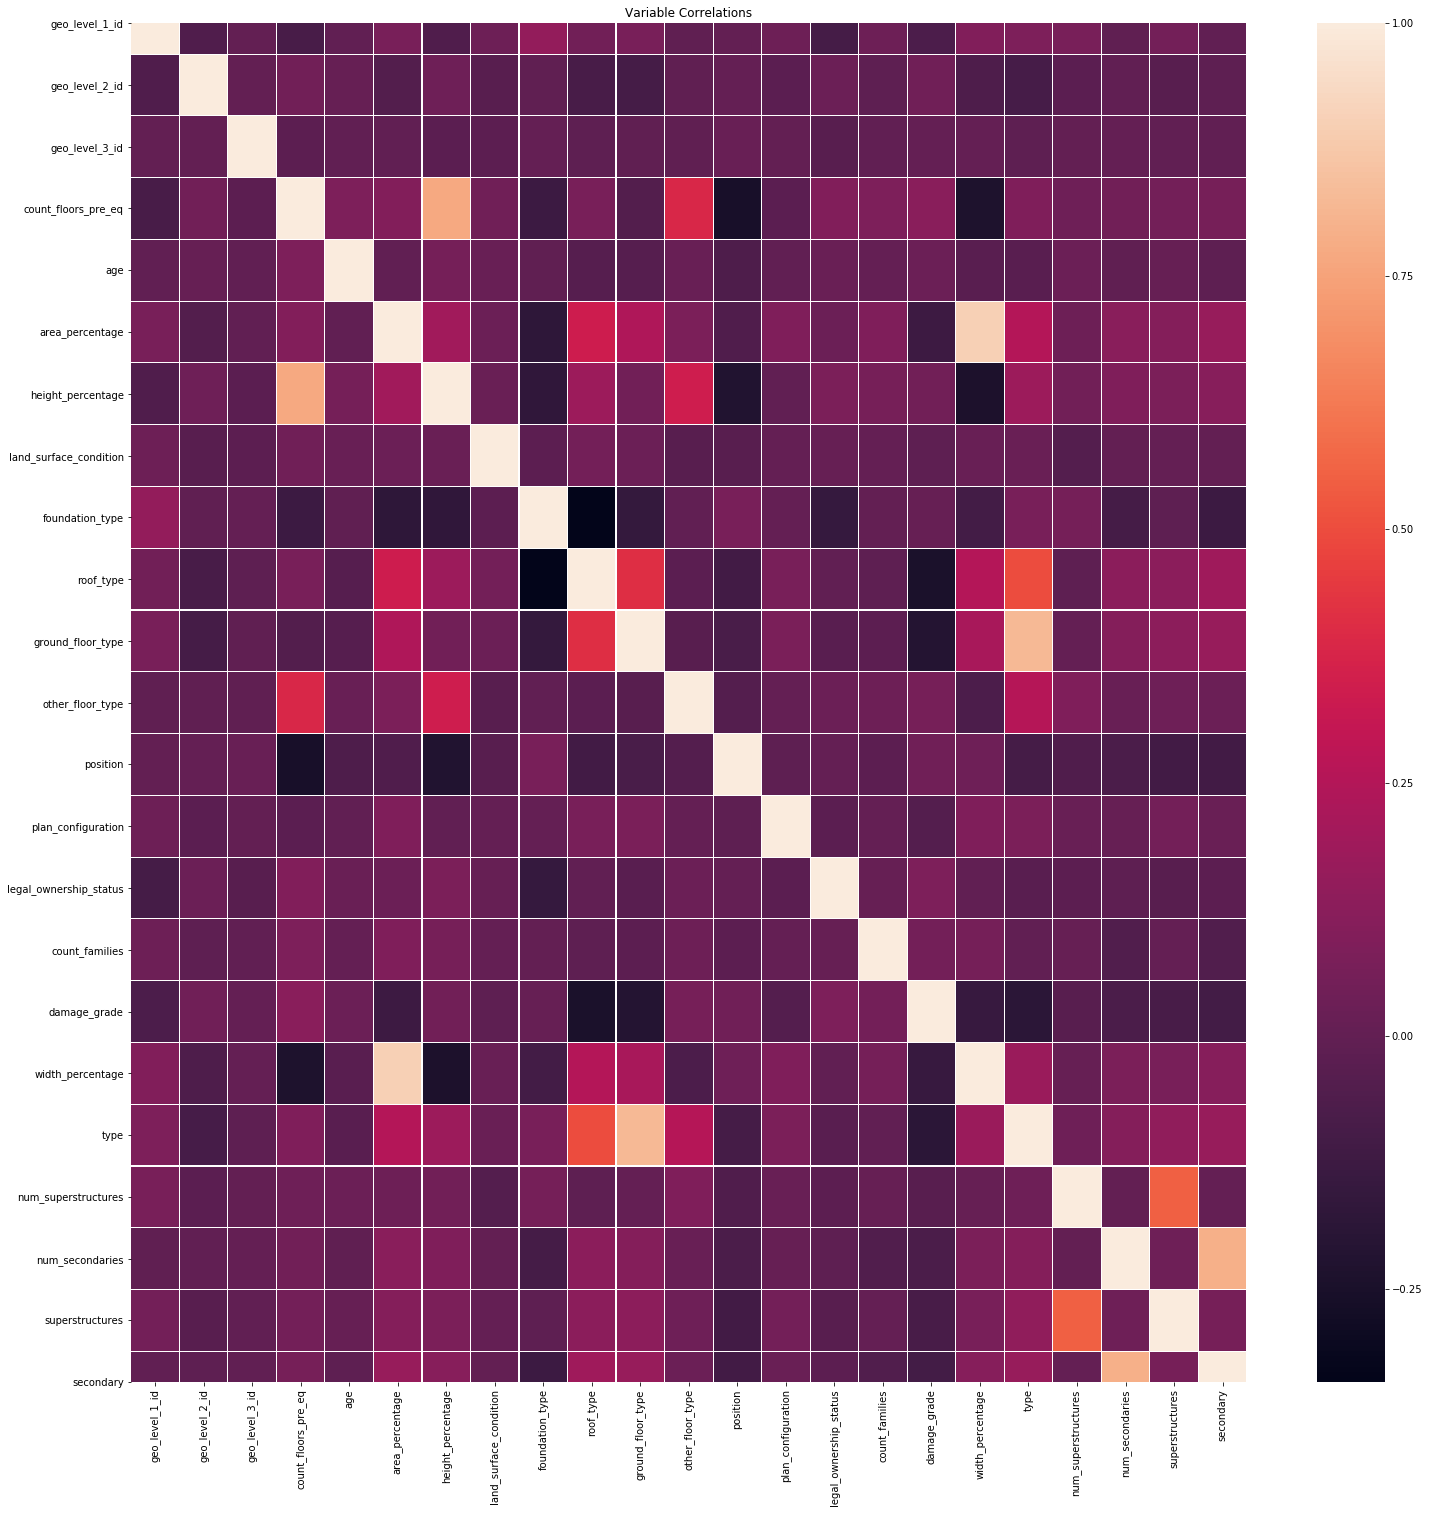

In [0]:
# feature correlation heatmap

import seaborn as sns
correlations = data.corr()
fig, ax = plt.subplots(figsize=(25,25))
corr_heat = sns.heatmap(correlations, linewidths=0.125, ax=ax)
plt.title('Variable Correlations')

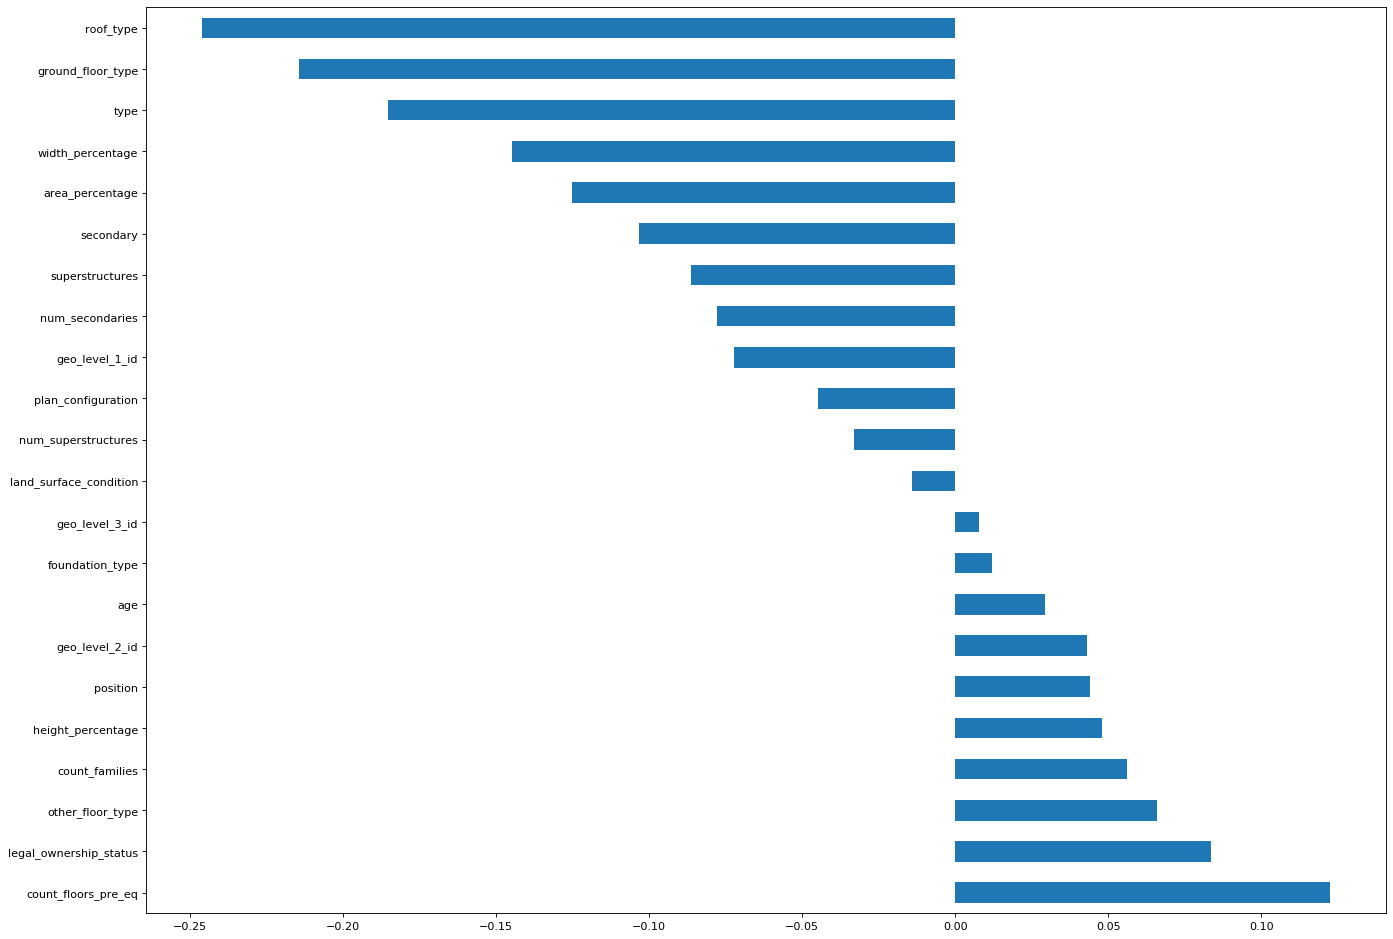

In [0]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(20,15), dpi=80, facecolor='w', edgecolor='k')
correlations.damage_grade.drop('damage_grade').sort_values(ascending=False).plot.barh()

In [0]:
features = data.drop('damage_grade', axis=1)

In [0]:
list_features = list(features.columns)
feature_length = len(list_features)

In [0]:
# determine the best features to use for the model

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

X = features # independent columns
y = data.damage_grade # target column

# apply SelectKBest class to extract best features
bestfeatures = SelectKBest(score_func=chi2, k=feature_length)
fit = bestfeatures.fit(X, y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

# concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns, dfscores],axis=1)
featureScores.columns = ['Feature','Score']  # naming the dataframe columns
print(featureScores.nlargest(feature_length,'Score'))  # print best features

del features, list_features, featureScores, dfcolumns, dfscores, X, y

                   Feature         Score
17                    type  1.069065e+08
20         superstructures  1.413440e+05
1           geo_level_2_id  1.282390e+05
4                      age  8.943760e+04
2           geo_level_3_id  8.366476e+04
10       ground_floor_type  6.436138e+04
0           geo_level_1_id  2.418695e+04
5          area_percentage  1.193831e+04
9                roof_type  1.187397e+04
21               secondary  9.550699e+03
16        width_percentage  4.010965e+03
19         num_secondaries  1.477297e+03
11        other_floor_type  1.267777e+03
3      count_floors_pre_eq  1.241172e+03
13      plan_configuration  7.419184e+02
14  legal_ownership_status  7.226304e+02
8          foundation_type  5.132784e+02
6        height_percentage  4.999709e+02
18     num_superstructures  3.863540e+02
15          count_families  1.689492e+02
7   land_surface_condition  1.010410e+02
12                position  8.222079e+01


In [0]:
data = reduce_mem_usage(data)

Memory usage of dataframe is 45.73 MB
Memory usage after optimization is: 7.46 MB
Decreased by 83.7%


In [0]:
data_test = reduce_mem_usage(data_test)

Memory usage of dataframe is 14.58 MB
Memory usage after optimization is: 2.40 MB
Decreased by 83.5%


In [0]:
# train valid split

from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(data.drop('damage_grade', axis=1), data.damage_grade, test_size=0.001, random_state=42)

In [0]:
print('Train:', X_train.shape[0])
print('Valid:', X_valid.shape[0])

Train: 260340
Valid: 261


In [0]:
# catboost model

!pip3 -q install catboost
from catboost import Pool, CatBoostClassifier

     |████████████████████████████████| 62.9MB 144kB/s 


In [0]:
train_pool = Pool(X_train, y_train)
cat_clf = CatBoostClassifier(loss_function='MultiClass', boosting_type='Ordered', bootstrap_type='Bayesian', od_type='Iter', iterations=25000, eval_metric='MultiClass', random_state=42)
cat_clf.fit(train_pool, eval_set=(X_valid, y_valid), early_stopping_rounds=1500, verbose=25)
cat_clf.best_score_

0:	learn: 1.0821497	test: 1.0818177	best: 1.0818177 (0)	total: 504ms	remaining: 3h 30m 5s
25:	learn: 0.8638172	test: 0.8507171	best: 0.8507171 (25)	total: 11.3s	remaining: 3h 1m 15s
50:	learn: 0.7874476	test: 0.7672503	best: 0.7672503 (50)	total: 22.1s	remaining: 3h 4s
75:	learn: 0.7539110	test: 0.7303968	best: 0.7303968 (75)	total: 32.9s	remaining: 3h 5s
100:	learn: 0.7371700	test: 0.7120141	best: 0.7120141 (100)	total: 43.8s	remaining: 2h 59m 56s
125:	learn: 0.7260195	test: 0.7019047	best: 0.7019047 (125)	total: 54.7s	remaining: 3h 2s
150:	learn: 0.7184388	test: 0.6939709	best: 0.6939709 (150)	total: 1m 5s	remaining: 2h 59m 51s
175:	learn: 0.7122379	test: 0.6879524	best: 0.6879524 (175)	total: 1m 16s	remaining: 2h 59m 46s
200:	learn: 0.7068760	test: 0.6825476	best: 0.6825476 (200)	total: 1m 27s	remaining: 2h 59m 42s
225:	learn: 0.7028089	test: 0.6781944	best: 0.6781944 (225)	total: 1m 38s	remaining: 2h 59m 37s
250:	learn: 0.6992935	test: 0.6744068	best: 0.6744068 (250)	total: 1m 49s	

{'learn': {'MultiClass': 0.5294669958353504},
 'validation': {'MultiClass': 0.5806677131993017}}

In [0]:
cat_clf.save_model('Earthquake_Damage_Catboost.hdf5')

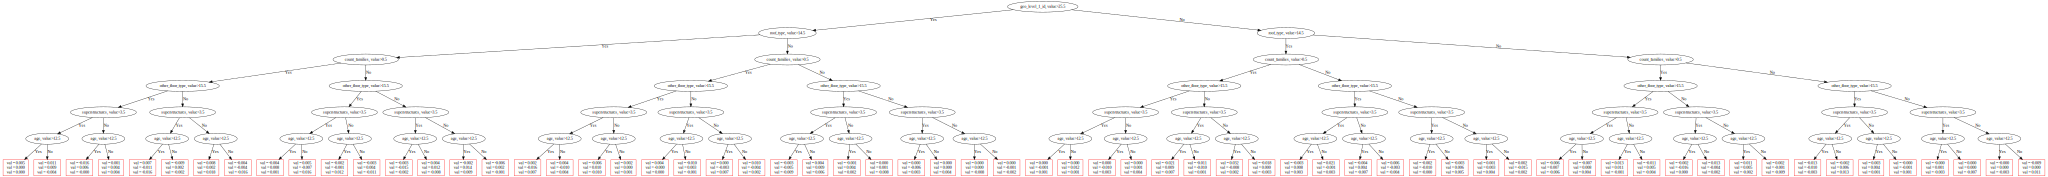

In [0]:
# visualize trees

cat_clf.plot_tree(tree_idx=123, pool=train_pool)

In [0]:
# feature importances

feature_stuff = dict(zip(cat_clf.feature_names_, cat_clf.feature_importances_))
feature_stuff

{'age': 3.9241954203462064,
 'area_percentage': 1.4755726301663588,
 'count_families': 0.6591058838291425,
 'count_floors_pre_eq': 1.795851941340568,
 'foundation_type': 3.705889365018061,
 'geo_level_1_id': 35.75252941160936,
 'geo_level_2_id': 20.726748370569375,
 'geo_level_3_id': 8.962930461008806,
 'ground_floor_type': 1.2486545431468183,
 'height_percentage': 1.568247336441896,
 'land_surface_condition': 0.7642984674704674,
 'legal_ownership_status': 0.32785749426417043,
 'num_secondaries': 0.3845179811594583,
 'num_superstructures': 1.521120011834345,
 'other_floor_type': 1.2143356633132636,
 'plan_configuration': 0.26018145519695235,
 'position': 0.7814813986582339,
 'roof_type': 2.6060870334365958,
 'secondary': 0.5809117112959893,
 'superstructures': 7.078820402161833,
 'type': 3.3811154056253603,
 'width_percentage': 1.2795476121067286}

In [0]:
feature_stuff = pd.DataFrame(zip(cat_clf.feature_names_, cat_clf.feature_importances_))

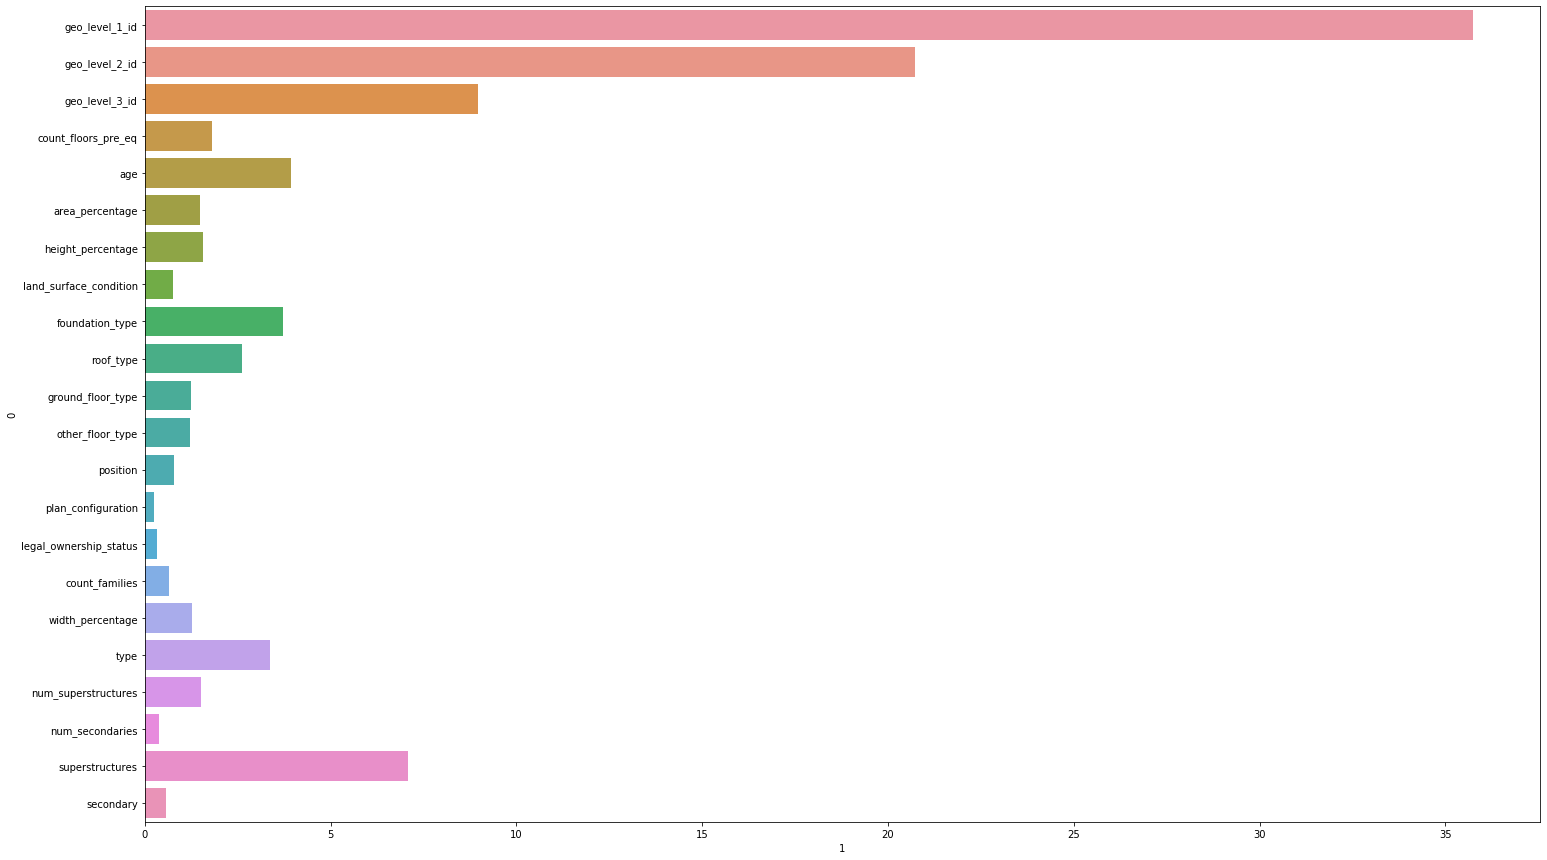

In [0]:
ax, f = plt.subplots(figsize=(25, 15))
sns.barplot(x=1, y=0, data=feature_stuff, label="Total")

In [0]:
# make predictions

Y_pred_cat = cat_clf.predict(data_test).astype(int)
Y_preds_cat = []
for i in Y_pred_cat:
  Y_preds_cat.append(i[0])
del Y_pred_cat

count1=0
count2=0
count3=0

for i in Y_preds_cat:
  if i==1:
    count1+=1
  elif i==2:
    count2+=1
  elif i==3:
    count3+=1
  else:
    print("Prediction Value Unacceptable")
    
print("1's:", count1)
print("2's:", count2)
print("3's:", count3)

1's: 6049
2's: 56639
3's: 24180


Text(0.5, 1.0, 'TRAIN: # of Buildings for each Damage Grade')

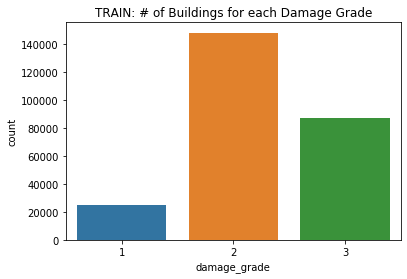

In [0]:
sns.countplot(data['damage_grade'])
plt.title('TRAIN: # of Buildings for each Damage Grade')

Text(0.5, 1.0, 'PREDICTIONS: # of Buildings for each Damage Grade')

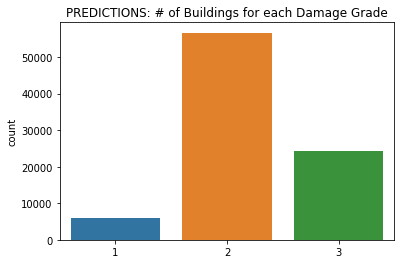

In [0]:
sns.countplot(Y_preds_cat)
plt.title('PREDICTIONS: # of Buildings for each Damage Grade')

In [0]:
submission_cat = pd.DataFrame({
    "building_id": building_ids,
    "damage_grade": Y_preds_cat
    })
del Y_preds_cat
submission_cat.head()

,building_id,damage_grade
0,300051,3
1,99355,2
2,890251,2
3,745817,1
4,421793,3


In [0]:
submission_cat.to_csv('EARTHQUAKE_DAMAGE_SUBMISSION_CAT.csv', index=False)
from google.colab import files
files.download('EARTHQUAKE_DAMAGE_SUBMISSION_CAT.csv')

In [0]:
# random forest model

from sklearn.ensemble import RandomForestClassifier
rnd_clf = RandomForestClassifier(n_estimators=1500, random_state=42)
rnd_clf.fit(data.drop('damage_grade', axis=1), data.damage_grade)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [0]:
# extract one tree

estimator = rnd_clf.estimators_[123]

In [0]:
# visualize tree

from sklearn.tree import export_graphviz
# export as dot file
export_graphviz(estimator, 
                out_file='tree.dot', 
                feature_names=X_train.columns,
                class_names=y_train.name,
                rounded=True, proportion=False, 
                precision=2, filled=True)
del estimator

In [0]:
# convert dot to png

from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

In [0]:
# plot tree

from IPython.display import Image
Image(filename = 'tree.png')

In [0]:
# feature importances

for feature_name, feature_importance in zip(X_train.columns, rnd_clf.feature_importances_):
    print(feature_name, feature_importance)

geo_level_1_id 0.1376692339133452
geo_level_2_id 0.13065673239847664
geo_level_3_id 0.14695788220044165
count_floors_pre_eq 0.01579073236679518
age 0.1197404068434464
area_percentage 0.07237049427011359
height_percentage 0.04507603111476874
land_surface_condition 0.01919422494504062
foundation_type 0.022427474099283435
roof_type 0.019832440027320222
ground_floor_type 0.011318178695099785
other_floor_type 0.011397646413613311
position 0.021998537311136563
plan_configuration 0.0090945626349737
legal_ownership_status 0.0077706157276724854
count_families 0.024845037961540653
width_percentage 0.07375680678086435
type 0.03208222822278567
num_superstructures 0.015342489508404911
num_secondaries 0.007082180627295572
superstructures 0.045086527164411985
secondary 0.01050953677316926


In [0]:
feature_stuff = pd.DataFrame(zip(X_train.columns, rnd_clf.feature_importances_))

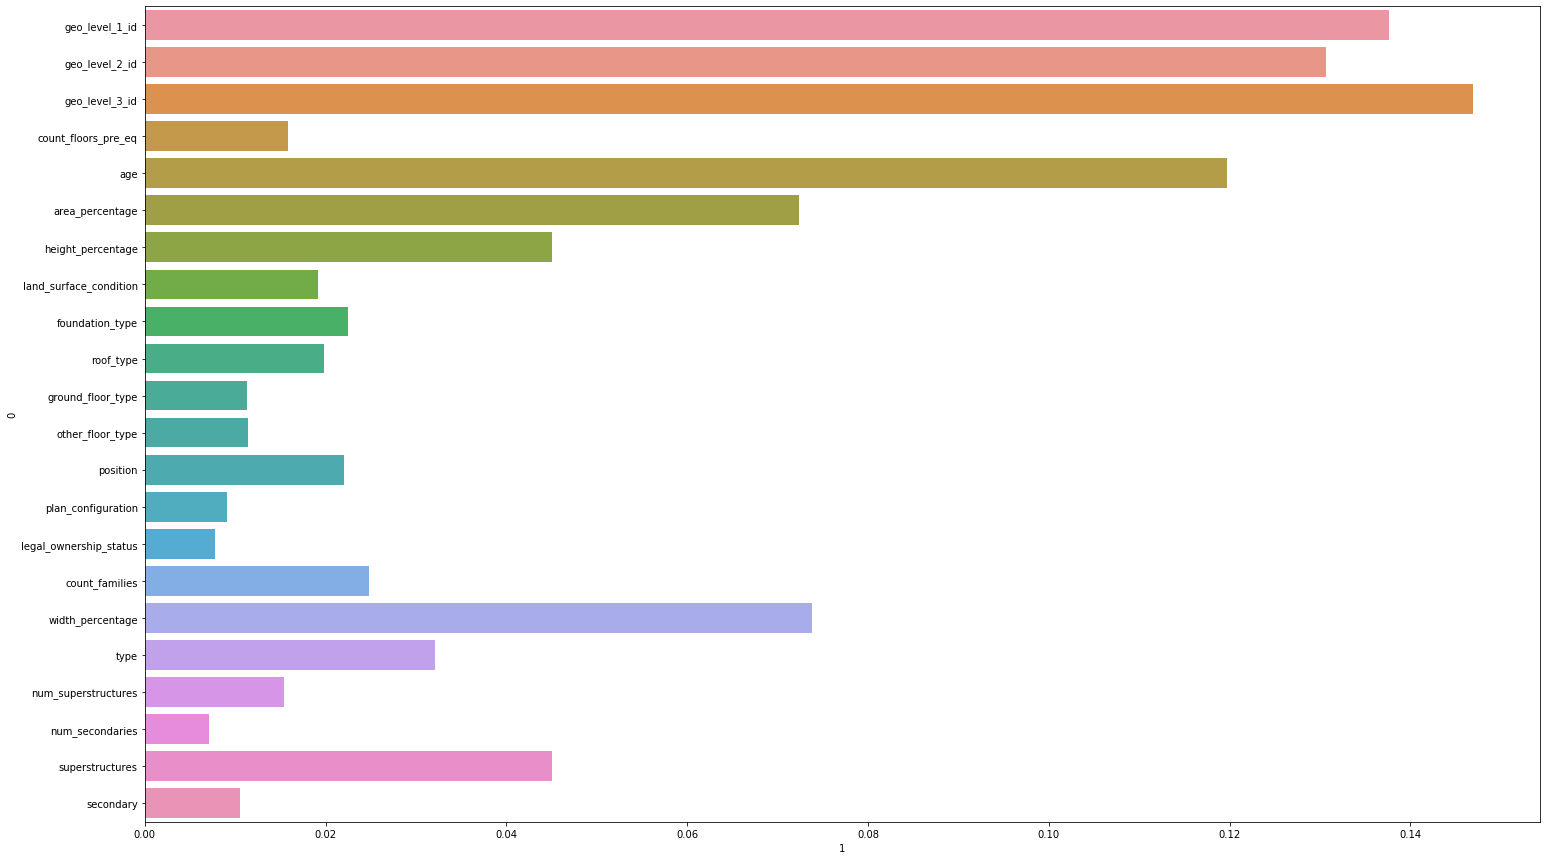

In [0]:
ax, f = plt.subplots(figsize=(25, 15))
sns.barplot(x=1, y=0, data=feature_stuff, label="Total")

In [0]:
data_test = data_test.fillna(505) # one more than the largest number superstructures were factorized into
data_test.isnull().sum()

geo_level_1_id            0
geo_level_2_id            0
geo_level_3_id            0
count_floors_pre_eq       0
age                       0
area_percentage           0
height_percentage         0
land_surface_condition    0
foundation_type           0
roof_type                 0
ground_floor_type         0
other_floor_type          0
position                  0
plan_configuration        0
legal_ownership_status    0
count_families            0
width_percentage          0
type                      0
num_superstructures       0
num_secondaries           0
superstructures           0
secondary                 0
dtype: int64

In [0]:
# make predictions

Y_preds_rnd = rnd_clf.predict(data_test).astype(int)

count1=0
count2=0
count3=0

for i in Y_preds_rnd:
  if i==1:
    count1+=1
  elif i==2:
    count2+=1
  elif i==3:
    count3+=1
  else:
    print("Prediction Value Unacceptable")
    
print("1's:", count1)
print("2's:", count2)
print("3's:", count3)

1's: 6107
2's: 56274
3's: 24487


Text(0.5, 1.0, 'TRAIN: # of Buildings for each Damage Grade')

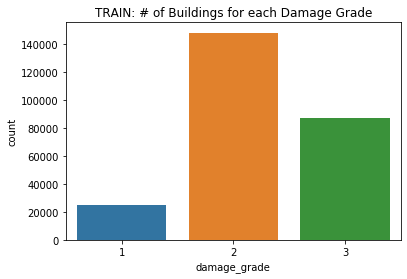

In [0]:
sns.countplot(data['damage_grade'])
plt.title('TRAIN: # of Buildings for each Damage Grade')

Text(0.5, 1.0, 'PREDICTIONS: # of Buildings for each Damage Grade')

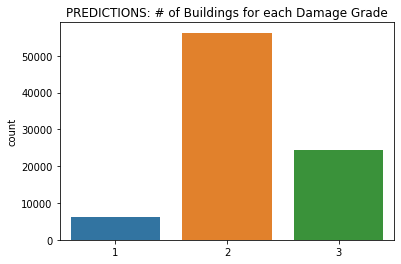

In [0]:
sns.countplot(Y_preds_rnd)
plt.title('PREDICTIONS: # of Buildings for each Damage Grade')

In [0]:
submission_rnd = pd.DataFrame({
    "building_id": building_ids,
    "damage_grade": Y_preds_rnd
    })
del Y_preds_rnd
submission_rnd.head()

,building_id,damage_grade
0,300051,2
1,99355,2
2,890251,2
3,745817,1
4,421793,3


In [0]:
submission_rnd.to_csv('EARTHQUAKE_DAMAGE_SUBMISSION_RNDM_FRST.csv', index=False)
from google.colab import files
files.download('EARTHQUAKE_DAMAGE_SUBMISSION_RNDM_FRST.csv')